# Feature Engineering

References: http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

The goals of a good feature are to simultaneously vary with what matters and be invariant with what doesn't. It is necessary to use background knowledge to design good features. Luckily, for many problems domains, there is already a vast literature of possible features and feature-types. **Choice can dratically affect performance**. 

There are in general two reasons why feature selection is used:
1. Reducing the number of features, to reduce overfitting and improve the generalization of models.
2. To gain better understanding of the features and their relationship to the response variables.

Feature selection is not particularly throughly covered in machine learning or data mining textbooks, partly becasue they are often looked as natural side effects of learning algorithms that don't require separate coverage.

### Univariate feature selection

Univariate feature selection examines each feature indiviadually to determine the strength of the relationship of the feature with the response variable. The problem is that these methods don't necessarily optimize the feature set for better generalization. It can work for selecting top features for model improvement in some settings, but it is **unable to remove redundancy**. There are a lot of different options for univariate selection:

### Pearson Correlation

In [2]:
import numpy as np
from scipy.stats import pearsonr

np.random.seed(0)
size = 300
x = np.random.normal(0,1,size)
print"Lower noise", pearsonr(x, x + np.random.normal(0,1,size))
print"Higher noise", pearsonr(x, x + np.random.normal(0,10,size))

Lower noise (0.71824836862138408, 7.3240173129983507e-49)
Higher noise (0.057964292079338155, 0.31700993885324752)


The firt result indicates a high correlation (0.71) with a low p-value. Therefore we can reject the hypothesis that the samples are not correlated. On the other hand, the second result indicates a low correlation with a non-statistically relevant p-value.

In [4]:
# Problem
x = np.random.uniform(-1,1, 10000)
print pearsonr(x, x**2)[0]

-0.0245054997263


### Maximal Information coefficient
https://en.wikipedia.org/wiki/Maximal_information_coefficient

In [3]:
from minepy import MINE
m = MINE()
x = np.random.uniform(-1,1,1000)
m.compute_score(x,x**2)
print m.mic()

1.0


There are at least two reasons why to prefer Pearson correlation over more sophisticated mothods such as MIC or distance correlation when the relationship is close to linear. Firstly, computing the Pearson correlation is much faster. Secondly, the range of the correlation coefficient [-1,1] instead of [0,1] for MIC and distance correlation relay useful extra information on whether the relationship is positive or negative.

### Model based ranking

In [6]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor

boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]

rf = RandomForestRegressor(n_estimators = 20, max_depth = 4)
scores = []
for i in range(X.shape[1]):
    score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2",
                           cv = ShuffleSplit(len(X),3,.3))
    scores.append((round(np.mean(score),3), names[i]))

print sorted(scores, reverse = True)

[(0.669, 'LSTAT'), (0.483, 'RM'), (0.422, 'NOX'), (0.328, 'PTRATIO'), (0.322, 'INDUS'), (0.282, 'TAX'), (0.279, 'RAD'), (0.204, 'CRIM'), (0.143, 'ZN'), (0.104, 'DIS'), (0.101, 'AGE'), (0.094, 'B'), (-0.013, 'CHAS')]


In [7]:
from sklearn.linear_model import LinearRegression

np.random.seed(0)
size = 5000

# A dataset with 3 features
X = np.random.normal(0,1, (size,3))
# Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0,2,size)
lr = LinearRegression()
lr.fit(X,Y)

def pretty_print_linear(coefs, names = None, sort=False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key=lambda x: -np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef,3), name) for coef, name in lst)

print "Linear model: ", pretty_print_linear(lr.coef_)

Linear model:  0.984 * X0 + 1.995 * X1 + -0.041 * X2


If variables has noise, as the below example, the model can predict well buy the feature weights are not correct because they don't show the real world relations.

In [8]:
from sklearn.linear_model import LinearRegression
 
size = 100
np.random.seed(seed=5)
 
X_seed = np.random.normal(0, 1, size)
X1 = X_seed + np.random.normal(0, .1, size)
X2 = X_seed + np.random.normal(0, .1, size)
X3 = X_seed + np.random.normal(0, .1, size)
  
Y = X1 + X2 + X3 + np.random.normal(0,1, size)
X = np.array([X1, X2, X3]).T
  
lr = LinearRegression()
lr.fit(X,Y)
print "Linear model:", pretty_print_linear(lr.coef_)

Linear model: -1.291 * X0 + 1.591 * X1 + 2.747 * X2


## Regularization

### L1 regularization / Lasso

L1 regularization adds a penalty to the loss function (L1-norm). Since each non-zero coefficient adds to the penalty, it forces weak features to have zero as coefficients. Thus L1 regularization produces sparse solutions, inherently performing feature selection.

For regression, Scikit-learn offers Lasso for linear regression and Logistic regression with L1 penalty for classification.

In [10]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
  
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]
  
lasso = Lasso(alpha=.3)
lasso.fit(X, Y)
  
print "Lasso model: ", pretty_print_linear(lasso.coef_, names, sort = True)

Lasso model:  -3.707 * LSTAT + 2.992 * RM + -1.757 * PTRATIO + -1.081 * DIS + -0.7 * NOX + 0.631 * B + 0.54 * CHAS + -0.236 * CRIM + 0.081 * ZN + -0.0 * INDUS + -0.0 * AGE + 0.0 * RAD + -0.0 * TAX


/Users/b3j90/anaconda/envs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### L2 regularization / Ridge regression

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
size = 100
 
#We run the method 10 times with different random seeds
for i in range(10):
    print "Random seed %s" % i
    np.random.seed(seed=i)
    X_seed = np.random.normal(0, 1, size)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
 
    lr = LinearRegression()
    lr.fit(X,Y)
    print "Linear model:", pretty_print_linear(lr.coef_)
 
    ridge = Ridge(alpha=10)
    ridge.fit(X,Y)
    print "Ridge model:", pretty_print_linear(ridge.coef_)
    print

Random seed 0
Linear model: 0.728 * X0 + 2.309 * X1 + -0.082 * X2
Ridge model: 0.938 * X0 + 1.059 * X1 + 0.877 * X2

Random seed 1
Linear model: 1.152 * X0 + 2.366 * X1 + -0.599 * X2
Ridge model: 0.984 * X0 + 1.068 * X1 + 0.759 * X2

Random seed 2
Linear model: 0.697 * X0 + 0.322 * X1 + 2.086 * X2
Ridge model: 0.972 * X0 + 0.943 * X1 + 1.085 * X2

Random seed 3
Linear model: 0.287 * X0 + 1.254 * X1 + 1.491 * X2
Ridge model: 0.919 * X0 + 1.005 * X1 + 1.033 * X2

Random seed 4
Linear model: 0.187 * X0 + 0.772 * X1 + 2.189 * X2
Ridge model: 0.964 * X0 + 0.982 * X1 + 1.098 * X2

Random seed 5
Linear model: -1.291 * X0 + 1.591 * X1 + 2.747 * X2
Ridge model: 0.758 * X0 + 1.011 * X1 + 1.139 * X2

Random seed 6
Linear model: 1.199 * X0 + -0.031 * X1 + 1.915 * X2
Ridge model: 1.016 * X0 + 0.89 * X1 + 1.091 * X2

Random seed 7
Linear model: 1.474 * X0 + 1.762 * X1 + -0.151 * X2
Ridge model: 1.018 * X0 + 1.039 * X1 + 0.901 * X2

Random seed 8
Linear model: 0.084 * X0 + 1.88 * X1 + 1.107 * X2
Ridg

## Natural Language Processing
### Contextual Features
#### n-grams
Exploit context by using sequences of n words intead of single words. A litle context improves performance: bigrams are usually better than unigrams. Usually no gain for n > 3.
#### position information

### Linguistic features
#### Stemming
It helps to represent terms that occur in different morphological variants. Remove inflections that convey parts of speech, tense and number: increase recall by decreasing precision. Sometimes is too agresive. It can be a good idea to use it with n-grams because the latter increase precision. 
Stemming + N-gram == Noun phrase extraction?
Techniques:
* Morphological analysis: Porter's algorithm, fast but low quality
* Dictionary Lookup: WordNet: slow, but more powerful.

#### Lemmatization
#### Noun phrases
N-grams can be improved. It can be used with part-of-speech (lexical category) to find noun phrases. Noun phrases 
### Structural features
#### Structural Markups
#### Hypertext
### Feature Subset Selection
Using each word as a feature results in thousands of features. Many of them are irrelevant and redundant, and therefore can cause overfitting. Moreover removing them can increase efficiency.
#### Unsupervised FSS
##### Using Domain Knowledge
Some features may be known to be irrelevant or redundant.
##### Random Sampling
Select a random sample of the feature can be appropriate in the case of many weakly relevant features and in connection with ensemble methods.
##### Frequency-based
Most frequent features may be bad, they usually are numbers and stop words. However, too much pruning may hurts.
* Fixed Number: keep n most frequent words
* Thresholding: keep all words that occur at least k times
* TF-IDF

#### Supervised FSS
##### Filter approaches
Compute some measure for estimating the ability to discriminate between classes. Typically it consists in computing a **feature weight** and select the best n features. Problems can arise becasue of **redundant features** that will have similar weights and **dependant features**, features with low weights because they are consider alone. A good feature should **discriminate documents of different classes**.
###### Discrimination measures
* Information Gain
* Log-odds ration
* The chi-square test
##### Wrapper approaches
They consist in searching through the space of all possible feature subsets. Each search subset is tried with the learning algorithm. It can be very **inefficient**: many learning cycles necessary.
###### Forward selection
Simple search heuristic: Keep adding one feature at every step util classifier's accuracy ceases to improve.
###### Backward selection

    1. Start with full feature set F
    2. Try to remove algorithms

#### Machine Learning methods
### Feature Construction
### Latent Semantic Indexing
### Stop Lists
#### Removal of frequently occurring words
This words occur in all documents and are statistically irrelevant.

**Problems**
* Different meanings
* Important in phrases
* Polysemous words -> Poor precision


In [1]:
%matplotlib inline

In [6]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C = 1)
rfe = RFE(estimator=svc, n_features_to_select = 1, step = 1)
rfe.fit(X,y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

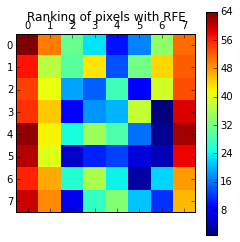

In [14]:
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of pixels with RFE")

## Recursive feature elimination with cross-validation

In [6]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

Optimal number of features: 15


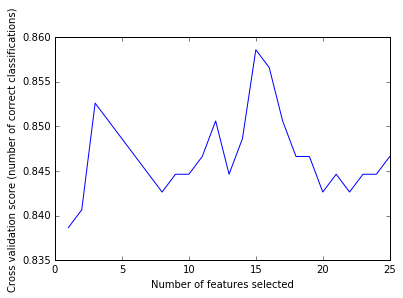

In [11]:
X, y = make_classification(n_samples=1000, n_features=25, n_informative=5,
                          n_redundant = 2, n_repeated = 0, n_classes = 2,
                          n_clusters_per_class = 1, random_state = 0)

svc = SVC(kernel='linear')
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y,2), scoring='recall')
rfecv.fit(X,y)
print("Optimal number of features: %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (number of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) +1), rfecv.grid_scores_)

In [40]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import numpy as np

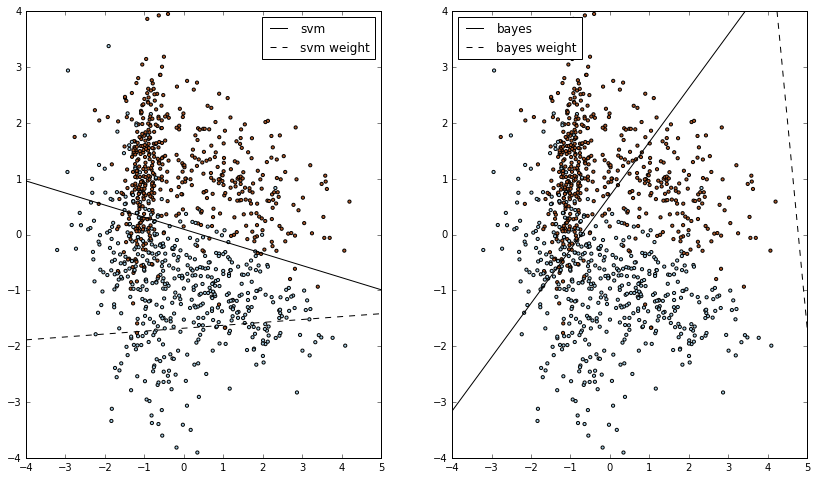

In [57]:
X, y = make_classification(n_samples=1000, n_features = 2, n_informative = 2,
                          n_redundant = 0, n_repeated = 0, n_classes = 2,
                          n_clusters_per_class = 2, random_state = 2016)


xx = np.linspace(-4,5)

clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X, y)

w = clf.coef_[0]
a = -w[0] / w[1]
yy = a * xx - clf.intercept_[0] / w[1]

clf = svm.SVC(kernel = 'linear', C = 1.0, class_weight={1:20})
clf.fit(X, y)
w = clf.coef_[0]
a = -w[0] / w[1]
yyw = a * xx - clf.intercept_[0]/ w[1]

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.xlim([-4,5])
plt.ylim([-4,4])
plt.scatter(X[:, 0], X[:, 1] , c = y, cmap = plt.cm.Paired, s = 10)
plt.plot(xx, yy, 'k-', label="svm")
plt.plot(xx, yyw, 'k--', label="svm weight")
plt.legend(loc="best")

clf = BernoulliNB()
clf.fit(X, y)

w = clf.coef_[0]
a = -w[0]
yy = a * xx - clf.intercept_[0]

clf = BernoulliNB(class_prior=[1,100])
clf.fit(X, y)
w = clf.coef_[0]
a = -w[0] / w[1]
yyw = a * xx - clf.intercept_[0]/ w[1]

plt.subplot(1,2,2)
plt.scatter(X[:, 0], X[:, 1] , c = y, cmap = plt.cm.Paired, s = 10)
plt.xlim([-4,5])
plt.ylim([-4,4])
plt.plot(xx, yy, 'k-', label="bayes")
plt.plot(xx, yyw, 'k--', label="bayes weight")
plt.legend(loc="best")
plt.show()

In [58]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import numpy as np

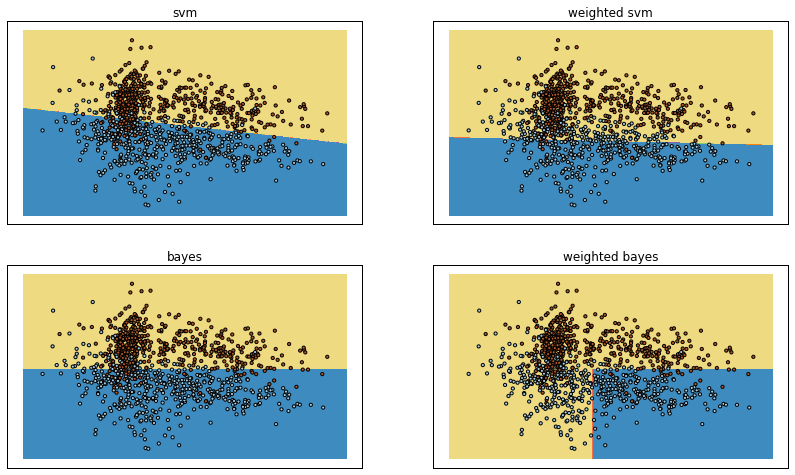

In [84]:
X, y = make_classification(n_samples=1000, n_features = 2, n_informative = 2,
                          n_redundant = 0, n_repeated = 0, n_classes = 2,
                          n_clusters_per_class = 2, random_state = 2016)


step = .02

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), 
                     np.arange(y_min, y_max, step))

names = ["svm", "weighted svm", "bayes", "weighted bayes"]
models = [
    svm.SVC(kernel='linear', C = 1.0),
    svm.SVC(kernel = 'linear', C = 1.0, class_weight={1:7}),
    BernoulliNB(),
    BernoulliNB(class_prior=[1, 7])
]

i = 1

plt.figure(figsize=(14,8))
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

for name, model in zip(names, models):
    model.fit(X, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.subplot(2,2,i)
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, c = y)
    plt.scatter(X[:, 0], X[:, 1] , c = y, cmap = plt.cm.Paired, s = 10)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')
    plt.title(name)
    i += 1

plt.show()

## SBS Algorithm
Source: https://github.com/rasbt/python-machine-learning-book

In [39]:
%matplotlib inline
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
class SBS():
    def __init__(self, estimator, k_features,
                 scoring = accuracy_score,
                 test_size = 0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def _calc_score(self, X_train, y_train,
                           X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size = self.test_size,
                                random_state = self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
                
            self.scores_.append(scores[best])

        self.k_score_ = self.scores_[-1]
            
        return self
        
        def transform(self, X):
            return X[:, self.indices_]
        

In [36]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [37]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
iris = datasets.load_iris()
X = iris.data
y_train = iris.target
X_train_std = StandardScaler().fit_transform(X, y_train)
sbs.fit(X_train_std, y_train)

In [38]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of featuers')
plt.grid()
plt.show()

## Univariate Feature Selection
Source: http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif

In [4]:
iris = datasets.load_iris()

# Some noisy data not correlated
E = np.random.uniform(0, 0.1, size = (len(iris.data), 20))

X = np.hstack((iris.data, E))
y = iris.target

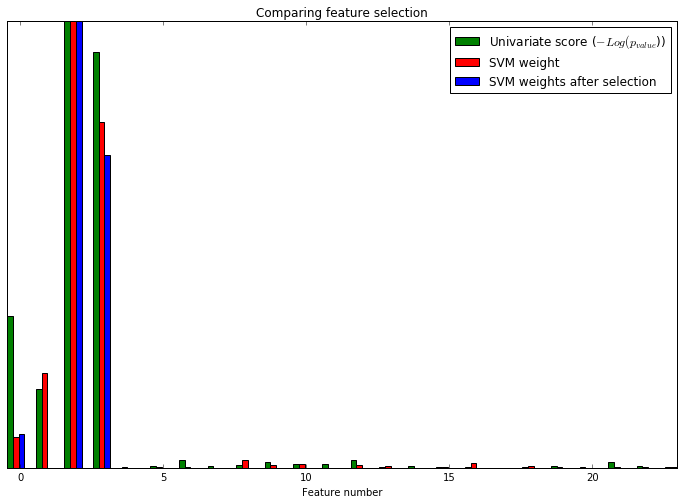

In [8]:
plt.figure(figsize=(12,8))
plt.clf()

X_indices = np.arange(X.shape[-1])

# Univariate feature selection with F-test for feature scoring
# Default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile = 10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r"Univariate score ($-Log(p_{value}$))", color="g")

clf = svm.SVC(kernel="linear")
clf.fit(X,y)

svm_weights = (clf.coef_ ** 2).sum(axis = 0)
svm_weights /= svm_weights.max()

plt.bar(X_indices  - .25, svm_weights, width = .2, label ="SVM weight", color ="r")
clf_selected = svm.SVC(kernel="linear")
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='b')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

## SVM-Anova: SVM with univariate feature selection
Source: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_anova.html

In [13]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, feature_selection, cross_validation
from sklearn.pipeline import Pipeline

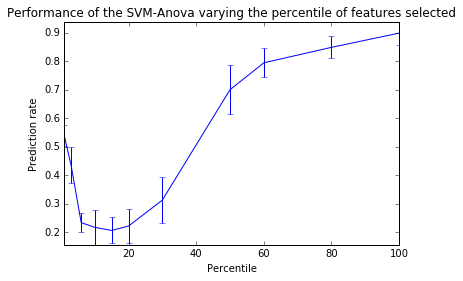

In [14]:
digits = datasets.load_digits()
y = digits.target
y = y[:200]
X = digits.data[:200]
n_samples = len(y)
X = X.reshape((n_samples, -1))
# add 200 not-informative features
X = np.hstack((X, 2 * np.random.random((n_samples, 200))))

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 50, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_validation.cross_val_score(clf, X, y, n_jobs =1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
    
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

## Pipelining: chaining a PCA and a logistic regression
Source: http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

In [11]:
logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline([('pca', pca),
                 ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [28]:
pca.fit(X_digits)

n_components = np.arange(1, 64, 4)
Cs = np.logspace(-4,4,3)

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C = Cs))

estimator.fit(X_digits, y_digits)

print("Best C: %.1f" % estimator.best_estimator_.named_steps['logistic'].C)
print("Best Number of components: %.1f" % estimator.best_estimator_.named_steps['pca'].n_components)

Best C: 1.0
Best Number of components: 41.0


/Users/b3j90/anaconda/envs/nlp/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


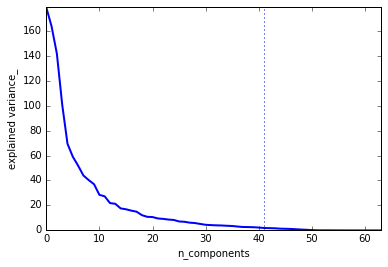

In [29]:
plt.legend(prop=dict(size=12))
plt.figure(1, figsize=(12, 4))

plt.plot(pca.explained_variance_, linewidth=2)
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
           linestyle=':', label="n_components chosen")
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained variance_')
plt.show()

## Recursive feature elimination with cross-validation
Source: http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#example-feature-selection-plot-rfe-with-cross-validation-py

In [35]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

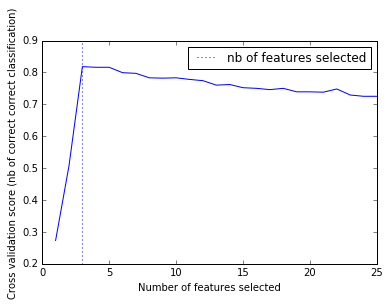

In [36]:
X, y = make_classification(n_samples = 1000, n_features = 25, n_informative = 3,
                           n_redundant = 2, n_repeated = 0, n_classes = 8, 
                           n_clusters_per_class=1, random_state = 0)

svc = SVC(kernel='linear')
rfecv = RFECV(estimator = svc, step = 1, cv =StratifiedKFold(y, 2), scoring='accuracy')
rfecv.fit(X, y)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct correct classification)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.axvline(rfecv.n_features_, linestyle=':', label="nb of features selected")
plt.legend(loc="better")
plt.show()

## Feature Union with Heterogeneous Data Sources
Source: http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import SVC

In [12]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data_dict):
        return data_dict[self.key]

class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text),
                 'num_sentences': text.count('.')}
                for text in posts]
    
class SubjectBodyExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass."""
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        features = np.recarray(shape=(len(posts),),
                               dtype=[('subject', object), ('body', object)])
        for i, text in enumerate(posts):
            headers, _, bod = text.partition('\n\n')
            bod = strip_newsgroup_footer(bod)
            bod = strip_newsgroup_quoting(bod)
            features['body'][i] = bod

            prefix = 'Subject:'
            sub = ''
            for line in headers.split('\n'):
                if line.startswith(prefix):
                    sub = line[len(prefix):]
                    break
            features['subject'][i] = sub

        return features
    

In [13]:
pipeline = Pipeline([
        ('subjectbody', SubjectBodyExtractor()),
        ('union', FeatureUnion(
            transformer_list=[
                    ('subject', Pipeline([
                                ('selector', ItemSelector(key='subject')),
                                ('tfidf', TfidfVectorizer(min_df = 50))
                            ])),
                    # Pipeline for standard bag-of-words model for body
                    ('body_bow', Pipeline([
                                ('selector', ItemSelector(key='body')),
                                ('tfidf', TfidfVectorizer()),
                                ('best', TruncatedSVD(n_components = 50)),
                            ])),
                    ('body_stats', Pipeline([
                                ('selector', ItemSelector(key='body')),
                                ('stats', TextStats()), # returns a list of dicts
                                ('vect', DictVectorizer()),
                            ])),
                ],
                transformer_weights = {
                    'subject': 0.8,
                    'body_bow': 0.5,
                    'body_stats': 1.0,
                },
            )),
        ('svc', SVC(kernel='linear')),
    ])

In [16]:
categories = ['alt.atheism', 'talk.religion.misc']
train = fetch_20newsgroups(random_state=1,
                           subset='train',
                           categories=categories,
                           )
test = fetch_20newsgroups(random_state=1,
                          subset='test',
                          categories=categories,
                          )

In [17]:
pipeline.fit(train.data, train.target)
y = pipeline.predict(test.data)
print(classification_report(y, test.target))

             precision    recall  f1-score   support

          0       0.62      0.80      0.70       249
          1       0.80      0.63      0.70       321

avg / total       0.72      0.70      0.70       570

